# Epsilon and utility tradeoff for PrivBayes

* Synthetic method: PrivBayes
* Dataset: generator-outputs/odi-nhs-ae/hospital_ae_data_deidentify.csv

This example runs the QUIPP pipeline using 20 input files in `examples/parameter_files/generated-privbayes-dr`. All of them use PrivBayes for synthesis but set different epsilons (there are 4 different epsilon values and 5 files per epsilon, each of which uses a different random seed). The notebook plots a graph of a utility score (1 - relative difference of F1 scores) against privacy (epsilon used in PrivBayes synthesis, where larger epsilon means less privacy).

In [1]:
import json
import os
import subprocess
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import argparse

### Input and output directories

In [3]:
json_files_path = "../../parameter_files/generated-privbayes-dr/"
inputs_path = "../../../run-inputs/"
outputs_path = "../../../synth-output/"
temp_path = '../../../temp-run-inputs/'

### Utility functions

In [4]:
def run_make_clean():
    """Runs make clean to reset all files."""
    cmd = '''
    cd ../../../
    make clean   
    '''
    subprocess.check_output(cmd, shell=True)

def prepare_parameter_files():
    """Temporarily store inputs_path files to new directory and copy all .json 
    parameter files from json_files_path to inputs_path."""   
    if not os.path.exists(temp_path):
        os.mkdir(temp_path)
    existing_file_names = os.listdir(inputs_path)    
    for f in existing_file_names:
        shutil.move(os.path.join(inputs_path, f), temp_path)
    
    new_file_names = os.listdir(path=json_files_path)
    for f in new_file_names:
        shutil.copyfile(os.path.join(json_files_path, f), os.path.join(inputs_path, f))

def run_pipeline():
    """Runs QUiPP pipeline for all enabled .json files in run-inputs
    Note: Can take several minutes depending on number of files and
    method used. Not all output is printed to the console. If you want to see
    all the output, you can run make from bash."""
    cmd = '''
    cd ../../../
    make   
    '''
    subprocess.check_output(cmd, shell=True)
    
def restore_original_parameter_files():
    """Delete the new json files from inputs_path and restore previously moved files."""    
    for f in os.listdir(inputs_path):        
        os.remove(os.path.join(inputs_path, f))
    
    original_file_names = os.listdir(temp_path)    
    for f in original_file_names:
        shutil.move(os.path.join(temp_path, f), inputs_path)

### Clean folders
Runs make clean

In [5]:
run_make_clean()

### Prepare files
Temporarily move existing .json files from run-inputs and replace them with the 20 .json files for this experiment 

In [6]:
prepare_parameter_files()

### Run pipeline

In [7]:
run_pipeline()

### Restore original files
Restores original .json files to run-inputs folder

In [8]:
restore_original_parameter_files()

### Collect results
Collect utility and privacy results

In [ ]:
f_list = os.listdir(path=json_files_path)
privacy_scores = []
epsilon_scores = []
utility_scores = []

for f in [os.path.splitext(name)[0] for name in f_list]:
    with open(os.path.join(outputs_path, f, "disclosure_risk.json")) as privacy_file:
        privacy_dict = json.load(privacy_file)
    privacy_scores.append(privacy_dict["EMRi_norm"])
    
    with open(os.path.join(outputs_path, f, f"{f}.json")) as parameters_file:
        parameters_dict = json.load(parameters_file)
    epsilon_scores.append(parameters_dict["parameters"]["epsilon"])

    with open(os.path.join(outputs_path, f, "utility_overall_diff.json")) as utility_file:
        utility_dict = json.load(utility_file)
        print(utility_file)
    utility_scores.append(utility_dict["overall"]["f1"]["macro"])

print(f"Privacy scores: {np.array(privacy_scores)}")
print(f"Epsilon scores: {np.array(epsilon_scores)}")
print(f"Utility scores: {np.array(utility_scores)}")

### Plot epsilon vs. utility
It seems that utility increases slightly with larger epsilon as expected

<_io.TextIOWrapper name='../../../synth-output/privbayes-example-13/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-12/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-3/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-8/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-19/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-4/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-15/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='../../../synth-output/privbayes-example-14/utility_overall_diff.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='..

<ipython-input-14-a123422f169f>:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=(0, 1000), ylim=(0.7, 1.00))


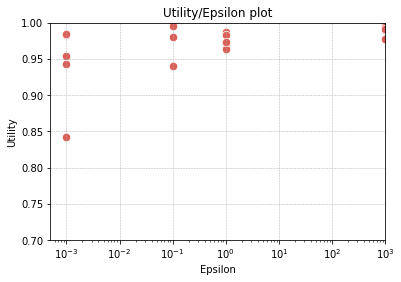

In [14]:
sns.set_palette("hls", 8)
ax = sns.scatterplot(x=np.array(epsilon_scores), y=1-np.array(utility_scores), s=70)
ax.set_xscale('log')
plt.title('Utility/Epsilon plot')
plt.xlabel('Epsilon')
plt.ylabel('Utility')
plt.grid(linestyle='--', linewidth=0.5)
ax.set(xlim=(0, 1000), ylim=(0.7, 1.00))
plt.show()

### Plot epsilon vs. Disclosure risk
It seems that there is a slight trend of increasing DR when epsilon increases - this is expected as DR measures the probability that an intruder achieves a successful match when they perform an attack (assuming they have partial knowledge of some columns and rows of the original dataset and they try to match each row with the most similar row in the synthetic data).

<ipython-input-23-aff38f5457b1>:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=(0, 1000), ylim=(0.0, 1.0))
<ipython-input-23-aff38f5457b1>:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=(0, 1000), ylim=(0.0, 1.0))


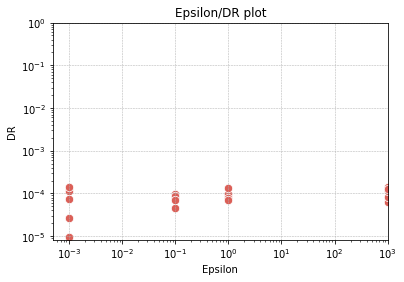

In [23]:
sns.set_palette("hls", 8)
ax = sns.scatterplot(x=np.array(epsilon_scores), y=np.array(privacy_scores), s=70)
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Epsilon/DR plot')
plt.xlabel('Epsilon')
plt.ylabel('DR')
plt.grid(linestyle='--', linewidth=0.5)
ax.set(xlim=(0, 1000), ylim=(0.0, 1.0))
plt.show()

### Plot Disclosure risk vs. Utility
There is no clear pattern here. The expected result would be to see an increase of utility when DR increases (= when privacy decreases)

<ipython-input-22-15269fd6fa1c>:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=(0, 1), ylim=(0.5, 1.03))


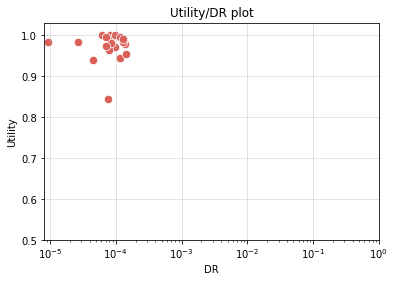

In [22]:
sns.set_palette("hls", 8)
ax = sns.scatterplot(x=np.array(privacy_scores), y=1-np.array(utility_scores), s=70)
ax.set_xscale('log')
plt.title('Utility/DR plot')
plt.xlabel('DR')
plt.ylabel('Utility')
plt.grid(linestyle='--', linewidth=0.5)
ax.set(xlim=(0, 1), ylim=(0.5, 1.03))
plt.show()